In [ ]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
! pip install rdkit
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install networkx
!pip install -q rdkit-pypi==2021.9.4
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install networkx

import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch_geometric.datasets as pyg_datasets
import torch_geometric.loader as pyg_loader
from torch_geometric.datasets import QM9
import torch_geometric.transforms as pyg_transforms
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_geometric.nn import MessagePassing, global_mean_pool, GATConv,GCNConv, GINConv, global_mean_pool,ChebConv,TransformerConv
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Crippen, QED, rdMolDescriptors, rdmolops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from google.colab import drive, files
drive.mount('/content/drive')
from torch import linalg as LA

Prepare dataset

In [ ]:
dataset = QM9(root='data/QM9')
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]

class QM9MoleculeSimilarityDataset(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDataset, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30): 
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30):  
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None



    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol

    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
      return similarity


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)


In [ ]:
similarity_threshold = 0.7
positive_ratio = 0.5

train_sim_dataset = QM9MoleculeSimilarityDataset(train_dataset, threshold=similarity_threshold, positive_ratio=positive_ratio)
val_sim_dataset = QM9MoleculeSimilarityDataset(val_dataset, threshold=similarity_threshold, positive_ratio=positive_ratio)
test_sim_dataset = QM9MoleculeSimilarityDataset(test_dataset, threshold=similarity_threshold, positive_ratio=positive_ratio)

train_sim_loader = DataLoader(train_sim_dataset, batch_size=64, shuffle=True,drop_last=True)
val_sim_loader = DataLoader(val_sim_dataset, batch_size=64, shuffle=False,drop_last=True)
test_sim_loader = DataLoader(test_sim_dataset, batch_size=64, shuffle=False,drop_last=True)

Models

In [ ]:
class GraphAttention(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(GraphAttention, self).__init__()
        self.attention = GATConv(in_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.attention(x, edge_index)

class GraphAttentionModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphAttentionModel, self).__init__()
        self.attention1 = GraphAttention(in_channels, hidden_channels, dropout=dropout)
        self.attention2 = GraphAttention(hidden_channels, hidden_channels, dropout=dropout)
        #self.attention3 = GraphAttention(hidden_channels, out_channels, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.attention1(x, edge_index)
        x = F.relu(x)
        x = self.attention2(x, edge_index)
        return global_mean_pool(x, data.batch)


class SiameseGraphAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.5):
        super(SiameseGraphAttentionModel, self).__init__()
        self.embedding = GraphAttentionModel(input_dim, hidden_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1) 

class GCNLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class GraphGCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super(GraphGCNModel, self).__init__()
        self.gcn1 = GCNLayer(in_channels, hidden_channels, dropout=dropout)
        self.gcn2 = GCNLayer(hidden_channels, out_channels, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gcn1(x, edge_index)
        x = self.gcn2(x, edge_index)
        return global_mean_pool(x, data.batch)

class SiameseGraphGCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.3):
        super(SiameseGraphGCNModel, self).__init__()
        self.embedding = GraphGCNModel(input_dim, hidden_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1)  

class GraphGIN(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0):
        super(GraphGIN, self).__init__()
        self.gin = GINConv(nn.Sequential(nn.Linear(in_channels, out_channels),
                                          nn.ReLU(),
                                          nn.Linear(out_channels, out_channels)))
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.gin(x, edge_index)


class GraphGINModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0):
        super(GraphGINModel, self).__init__()
        self.gin1 = GraphGIN(in_channels, hidden_channels, dropout=dropout)
        self.gin2 = GraphGIN(hidden_channels, hidden_channels, dropout=dropout)
        #self.gin3 = GraphGIN(hidden_channels, out_channels, dropout=dropout)
   

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gin1(x, edge_index)
        x = F.relu(x)
        x = self.gin2(x, edge_index)
        return global_mean_pool(x, data.batch)


class SiameseGraphGINModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0):
        super(SiameseGraphGINModel, self).__init__()
        self.embedding = GraphGINModel(input_dim, hidden_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1) 

class ChebNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, K=4, dropout=0.5):
        super(ChebNetLayer, self).__init__()
        self.cheb = ChebConv(in_channels, out_channels, K)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.cheb(x, edge_index)

class ChebNetModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K, dropout=0.5):
        super(ChebNetModel, self).__init__()
        self.cheb1 = ChebNetLayer(in_channels, hidden_channels, K, dropout=dropout)
        self.cheb2 = ChebNetLayer(hidden_channels, hidden_channels, K, dropout=dropout)
        self.cheb3 = ChebNetLayer(hidden_channels, out_channels, K, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.cheb1(x, edge_index)
        x = F.relu(x)
        x = self.cheb2(x, edge_index)
        x = F.relu(x)
        x = self.cheb3(x, edge_index)
        return global_mean_pool(x, data.batch)

class SiameseChebNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, K, dropout=0.5):
        super(SiameseChebNetModel, self).__init__()
        self.embedding = ChebNetModel(input_dim, hidden_dim, hidden_dim, K, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1) 
        
class CNNModel(nn.Module):
    def __init__(self, fingerprint_size, hidden_size, output_size, dropout=0.5):
        super(CNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(hidden_size * (fingerprint_size // 4), output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class SiameseCNNModel(nn.Module):
    def __init__(self, fingerprint_size, hidden_size, dropout=0.5):
        super(SiameseCNNModel, self).__init__()
        self.embedding = CNNModel(fingerprint_size, hidden_size, hidden_size, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, fp1, fp2):
        embedding1 = self.embedding(fp1)
        embedding2 = self.embedding(fp2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1)


class TransformerLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(TransformerLayer, self).__init__()
        self.transformer = TransformerConv(
            in_channels,
            out_channels,
            heads=1,
            edge_dim=None,
            dropout=dropout,
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.transformer(x, edge_index)


class TransformerModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.transformer1 = TransformerLayer(in_channels, hidden_channels, dropout=dropout)
        self.transformer2 = TransformerLayer(hidden_channels, out_channels, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.transformer1(x, edge_index)
        x = F.relu(x)
        x = self.transformer2(x, edge_index)
        return global_mean_pool(x, data.batch)


class SiameseTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.5):
        super(SiameseTransformerModel, self).__init__()
        self.embedding = TransformerModel(input_dim, hidden_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1)




In [ ]:
# NOTE THIS CODE IS ADAPTED FROM GDL LABS
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        super().__init__(aggr=aggr)
        self.emb_dim = emb_dim
        self.edge_dim = edge_dim    
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        return self.propagate(edge_index, h=h, edge_attr=edge_attr)

    def message(self, h_i, h_j, edge_attr):
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):

        super().__init__()
        self.lin_in = Linear(in_dim, emb_dim)
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        self.pool = global_mean_pool
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        h = self.lin_in(data.x) 
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) 


        h_graph = self.pool(h, data.batch) 
        out = self.lin_pred(h_graph)
        return out.view(-1)

class InvariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        super().__init__(aggr=aggr)
        self.emb_dim = emb_dim
        self.edge_dim = edge_dim
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        

    def forward(self, h, pos, edge_index, edge_attr):

        return self.propagate(edge_index, h=h,pos=pos,edge_attr=edge_attr)

    def message(self, h_i, h_j, pos_i, pos_j, edge_attr):
      dist = ((pos_i - pos_j).pow(2).sqrt()) 
      #print(dist.size())

      #print("dist after norm")
      dist = torch.norm(dist,dim=-1)
      #print(dist.size())
      #print("dist after reshape")
      dist=dist.reshape(-1,1)
      #print(dist.size())
      msg = torch.cat([h_i, h_j, edge_attr,dist], dim=-1)
      #print(msg.size())
      return self.mlp_msg(msg)

    
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class InvariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        super().__init__()
        self.lin_in = Linear(in_dim, emb_dim)
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(InvariantMPNNLayer(emb_dim, edge_dim, aggr='add'))
        self.pool = global_mean_pool
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        h = self.lin_in(data.x) 
        for conv in self.convs:
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr)  
        h_graph = self.pool(h, data.batch) 
        return h_graph

class SiameseInvariantMPNNModel(nn.Module):
    def __init__(self, num_layers=2, emb_dim=64, in_dim=11, edge_dim=4, dropout=0.5):
        super(SiameseInvariantMPNNModel, self).__init__()
        self.embedding = InvariantMPNNModel(num_layers, emb_dim, in_dim, edge_dim)
        self.fc = nn.Sequential(
            nn.Linear(2 * emb_dim, emb_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(emb_dim, 1)
        )

    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity =  torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1)


In [ ]:
class EquivariantMPNNLayer(InvariantMPNNLayer):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        super().__init__(emb_dim=emb_dim, edge_dim=edge_dim, aggr=aggr)

    def forward(self, h, pos, edge_index, edge_attr):
        out = self.propagate(edge_index, h=h, pos=pos, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, pos_i, pos_j, edge_attr):
        dist = (pos_i - pos_j).pow(2).sum(dim=-1).sqrt().unsqueeze(-1)
        msg = torch.cat([h_i, h_j, edge_attr, dist], dim=-1)
        return self.mlp_msg(msg)

    def update(self, aggr_out, h, pos):
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

class EquivariantMPNNModel(InvariantMPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        super().__init__(num_layers=num_layers, emb_dim=emb_dim, in_dim=in_dim, edge_dim=edge_dim, out_dim=out_dim)

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

    def forward(self, data):
        h = self.lin_in(data.x)
        for conv in self.convs:
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr)
        h_graph = self.pool(h, data.batch)
        return h_graph

class SiameseEquivariantMPNNModel(nn.Module):
    def __init__(self, num_layers=2, emb_dim=64, in_dim=11, edge_dim=4, dropout=0.5):
        super(SiameseEquivariantMPNNModel, self).__init__()
        self.embedding = EquivariantMPNNModel(num_layers, emb_dim, in_dim, edge_dim)
        self.fc = nn.Sequential(
            nn.Linear(2 * emb_dim, emb_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(emb_dim, 1)
        )
    def forward(self, data1, data2):
        embedding1 = self.embedding(data1)
        embedding2 = self.embedding(data2)
        combined = torch.cat((embedding1, embedding2), dim=-1)
        similarity = torch.sigmoid(self.fc(combined))
        return similarity.unsqueeze(-1)

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    true_labels = []
    pred_scores = []

    for data1, data2, label in loader:
        data1, data2, label = data1.to(device), data2.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(data1, data2)
        out = out.squeeze(-1) 
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        true_labels.extend(label.detach().cpu().numpy())
        pred_scores.extend(out.detach().cpu().numpy())

    return total_loss / len(loader.dataset), true_labels, pred_scores


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    true_labels = []
    pred_scores = []

    with torch.no_grad():
        for data in loader:
            data1, data2, label = data[0].to(device), data[1].to(device), data[2].to(device)
            out = model(data1, data2)
            out = out.squeeze(-1)
            loss = criterion(out, label)

            total_loss += loss.item()
            true_labels.extend(label.detach().cpu().numpy())
            pred_scores.extend(out.detach().cpu().numpy())

    return total_loss / len(loader.dataset), true_labels, pred_scores


def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    pred_scores = []

    with torch.no_grad():
        for data in loader:
            data1, data2, label = data[0].to(device), data[1].to(device), data[2].to(device)
            out = model(data1, data2)
            out = out.squeeze(-1)
            pred = (out > 0.5).float()

            correct += (pred == label).sum().item()
            total += label.size(0)

            true_labels.extend(label.detach().cpu().numpy())
            pred_scores.extend(out.detach().cpu().numpy())

    return correct / total, true_labels, pred_scores

def train_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, patience=5):
    best_val_acc = 0
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []
    train_accs=[]
    val_accs = []
    positive_scores = []
    negative_scores = []
    val_Y_true = []
    val_Y_pred = []

    for epoch in range(300):  
        train_loss, train_true_labels, train_pred_scores = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_true_labels, val_pred_scores = evaluate(model, val_loader, criterion, device)
        
        val_acc, val_Y_true_epoch, val_Y_pred_epoch = test(model, val_loader, device)
        train_acc, train_Y_true_epoch, train_Y_pred_epoch = test(model, train_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)

        positive_scores.extend([pred for i, pred in enumerate(val_pred_scores) if val_true_labels[i] == 1])
        negative_scores.extend([pred for i, pred in enumerate(val_pred_scores) if val_true_labels[i] == 0])
        val_Y_true.extend(val_true_labels)
        val_Y_pred.extend(val_pred_scores)

        print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"No improvement for {patience} epochs. Stopping early...")
                break

    return train_losses, val_losses, train_accs, val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred


TRAIN GAT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
times=[]
test_accs=[]
for i in range(10):
  in_channels = 11 
  model = SiameseGraphAttentionModel(input_dim=11, hidden_dim=100,dropout=0).to(device)
  total_params = sum(
    param.numel() for param in model.parameters()
  )
  print("Number of parameters: ",total_params)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  start = time.time()
  train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
  end = time.time()
  elapsed = end- start
  print("Time taken: ", elapsed)
  times.append(elapsed)
  test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
  test_accs.append(test_accuracy)
  print(f"Test Accuracy: ", test_accuracy)
print(np.mean(times))
print(np.mean(test_accs))

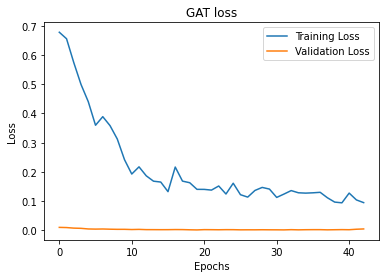

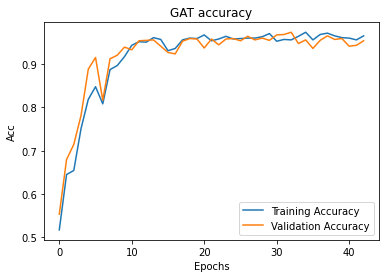

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GAT loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('GAT accuracy')
plt.show()

TRAIN GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
times=[]
test_accs=[]
for i in range(10):
  in_channels = 11 
  model = SiameseGraphGCNModel(input_dim=11, hidden_dim=100,dropout=0).to(device)
  total_params = sum(
    param.numel() for param in model.parameters()
  )
  print("Number of parameters: ",total_params)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  start = time.time()
  train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
  end = time.time()
  elapsed = end- start
  print("Time taken: ", elapsed)
  times.append(elapsed)
  test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
  test_accs.append(test_accuracy)
  print(f"Test Accuracy: ", test_accuracy)
print(np.mean(times))
print(np.mean(test_accs))

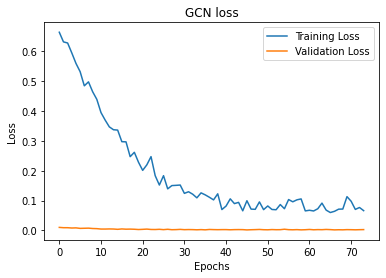

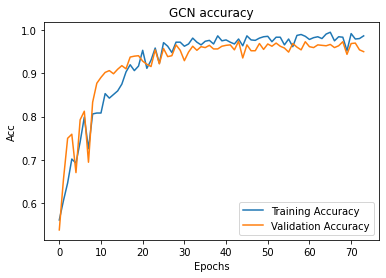

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GCN loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('GCN accuracy')
plt.show()

TRAIN GIN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
times=[]
test_accs=[]
for i in range(10):
  in_channels = 11 
  model = SiameseGraphGINModel(input_dim=11, hidden_dim=100,dropout=0).to(device)
  total_params = sum(
    param.numel() for param in model.parameters()
  )
  print("Number of parameters: ",total_params)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  start = time.time()
  train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
  end = time.time()
  elapsed = end- start
  print("Time taken: ", elapsed)
  times.append(elapsed)
  test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
  test_accs.append(test_accuracy)
  print(f"Test Accuracy: ", test_accuracy)
print(np.mean(times))
print(np.mean(test_accs))

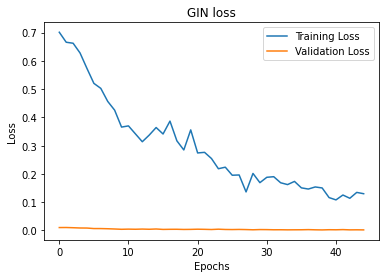

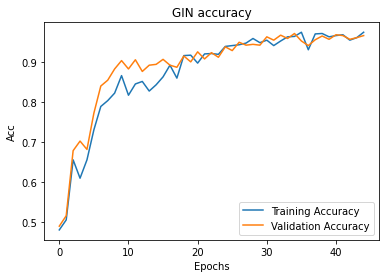

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GIN loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('GIN accuracy')
plt.show()

TRAIN CHEBNET

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
times=[]
test_accs=[]
for i in range(10):
  in_channels = 11 
  model = SiameseChebNetModel(input_dim=11, hidden_dim=100,K=4,dropout=0).to(device)
  total_params = sum(
    param.numel() for param in model.parameters()
  )
  print("Number of parameters: ",total_params)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  start = time.time()
  train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
  end = time.time()
  elapsed = end- start
  print("Time taken: ", elapsed)
  times.append(elapsed)
  test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
  test_accs.append(test_accuracy)
  print(f"Test Accuracy: ", test_accuracy)
print(np.mean(times))
print(np.mean(test_accs))

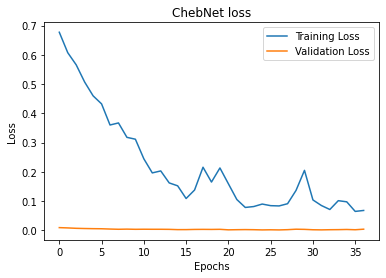

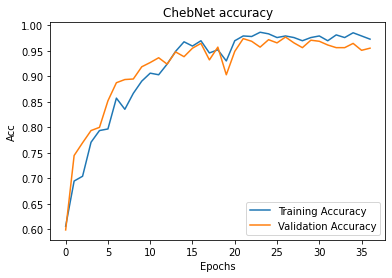

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ChebNet loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('ChebNet accuracy')
plt.show()

TRAIN TRANSFORMER

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
times=[]
test_accs=[]
for i in range(1):
  in_channels = 11 
  model = SiameseTransformerModel(input_dim=11, hidden_dim=128,dropout=0).to(device)
  total_params = sum(
    param.numel() for param in model.parameters()
  )
  print("Number of parameters: ",total_params)
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

  start = time.time()
  train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
  end = time.time()
  elapsed = end- start
  print("Time taken: ", elapsed)
  times.append(elapsed)
  test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
  test_accs.append(test_accuracy)
  print(f"Test Accuracy: ", test_accuracy)
print(np.mean(times))
print(np.mean(test_accs))

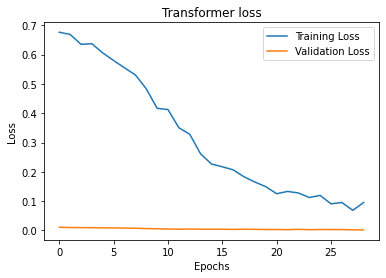

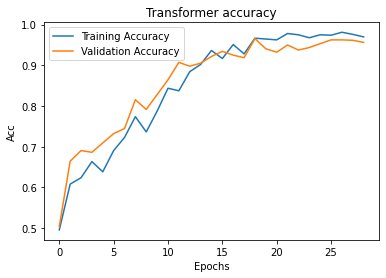

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('Transformer accuracy')
plt.show()

TRAIN CNN

In [ ]:
from torch_geometric.data import Dataset, Data
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors
import random
from torch_geometric.data import InMemoryDataset, DataLoader

dataset = QM9(root='data/QM9')

import torch
import torch.nn as nn
import torch.nn.functional as F
class QM9MoleculeSimilarityDataset(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDataset, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30): 
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30): 
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None



    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol




    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
      return similarity


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

      
        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)

class FingerprintSimilarityDataset(QM9MoleculeSimilarityDataset):
    def __getitem__(self, index):
        data1, data2, label = super(FingerprintSimilarityDataset, self).get(index)
        mol1 = self._get_rdkit_mol(data1)
        mol2 = self._get_rdkit_mol(data2)

        fp1 = torch.tensor(self._get_fingerprint(mol1), dtype=torch.float)
        fp2 = torch.tensor(self._get_fingerprint(mol2), dtype=torch.float)

        return fp1, fp2, label

train_fp_dataset = FingerprintSimilarityDataset(train_dataset, threshold=0.7, positive_ratio=0.5)
val_fp_dataset = FingerprintSimilarityDataset(val_dataset, threshold=0.7, positive_ratio=0.5)
test_fp_dataset = FingerprintSimilarityDataset(test_dataset, threshold=0.7, positive_ratio=0.5)

train_fp_loader = DataLoader(train_fp_dataset, batch_size=32, shuffle=True, drop_last=True)
val_fp_loader = DataLoader(val_fp_dataset, batch_size=32, shuffle=False, drop_last=True)
test_fp_loader = DataLoader(test_fp_dataset, batch_size=32, shuffle=False, drop_last=True)


In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in dataloader:
        fp1, fp2, labels = [t.to(device) for t in batch]
        optimizer.zero_grad()
        outputs = model(fp1, fp2)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        correct += ((outputs > 0.5) == labels.unsqueeze(1)).sum().item()

    return running_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            fp1, fp2, labels = [t.to(device) for t in batch]
            outputs = model(fp1, fp2)
            loss = criterion(outputs, labels.unsqueeze(1))

            running_loss += loss.item()
            total += labels.size(0)
            correct += ((outputs > 0.5) == labels.unsqueeze(1)).sum().item()

    return running_loss / len(dataloader), correct / total

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    pred_scores = []
    with torch.no_grad():
        for data in loader:
            data1, data2, label = data[0].to(device), data[1].to(device), data[2].to(device)
            out = model(data1, data2)
            out = out.squeeze(-1)
            pred = (out > 0.5).float()
            correct += (pred == label).sum().item()
            total += label.size(0)
            
            true_labels.extend(label.cpu().numpy())
            pred_scores.extend(out.cpu().numpy())

    test_accuracy = correct / total
    return test_accuracy, true_labels, pred_scores


def train_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, patience=5):
    best_val_acc = 0
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    train_accs=[]
    val_accs=[]
    val_y_true = []
    val_y_pred = []

    for epoch in range(100):  
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print("epoch ", epoch)
        print("train loss ", train_loss)
        print("val loss ", val_loss)
        print("val acc ", val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break

        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                fp1, fp2, labels = [t.to(device) for t in batch]
                outputs = model(fp1, fp2)
                val_y_true.extend(labels.cpu().numpy())
                val_y_pred.extend(outputs.squeeze().cpu().numpy())

    return train_losses, val_losses,train_accs,val_accs, val_y_true, val_y_pred

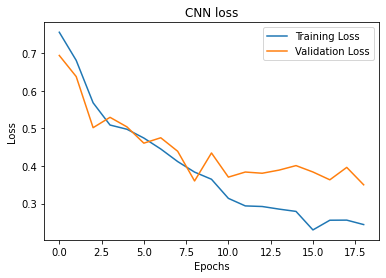

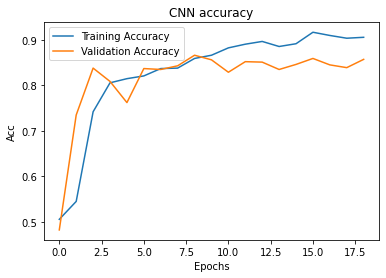

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('CNN accuracy')
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseInvariantMPNNModel(num_layers=2, emb_dim=128, in_dim=11, edge_dim=4, dropout=0).to(device)
total_params = sum(
    param.numel() for param in model.parameters()
  )
print("Number of parameters: ",total_params)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
start=time.time()
train_losses, val_losses, train_accs,val_accs, positive_scores, negative_scores, val_Y_true, val_Y_pred= train_early_stopping(model, train_sim_loader, val_sim_loader, criterion, optimizer, device, patience=10)
end = time.time()
elapsed = end- start
print("Time taken: ", elapsed)
test_accuracy,true_labels, pred_scores = test(model, test_sim_loader, device)
print("test acc: ", test_accuracy)
   

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Invariant MPNN loss')
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.title('Invariant MPNN accuracy')
plt.show()